Assignment 4: 

Name: Jeffin Johny K

UID: 118293929

Course: CMSC733

Please submit to ELMS
- a PDF containing all outputs (by executing **Run all**)
- your ipynb notebook containing all the code

I understand the policy on academic integraty (collaboration and the use of online material).
Please sign your name here: Jeffin Johny Kachappilly 

In [39]:
## Import necessary libraries here (You can add libraries you want to use here)
from skimage.util import img_as_float
from skimage import io, color
from skimage import draw
import matplotlib.pyplot as plt
import argparse, time
import math, copy
import numpy as np
import scipy.io
import cv2
from PIL import Image, ImageDraw
from scipy.io import loadmat

import time

from sklearn.mixture import GaussianMixture as GMM

In [24]:
def show_image(img, caption , scale=4.0  ):
    plt.figure(figsize=scale* plt.figaspect(1))
    plt.imshow(img, interpolation='nearest')
    plt.gray() 
    plt.axis('off')
    plt.title(caption)
    plt.show()



# Part 1: SLIC Superpixels (50 Points)

## Overview

Superpixel algorithms group pixels into perceptually meaningful regions while respecting potential object contours, and thereby can replace the rigid pixel grid structure. Due to the reduced complexity, superpixels are becoming popular for various computer vision applications, e.g., multiclass object segmentation, depth estimation, human pose estimation, and object localization.

In this problem, you will implement a simple superpixel algorithm called Simple Linear Iterative Clustering (SLIC) that clusters pixels in the five-dimensional color and pixel coordinate space (e.g., r, g, b, x, y). The algorithm starts with a collection of K cluster centers initialized at an equally sampled regular grid on the image of N pixels. For each cluster, you define for a localized window 2S x 2S centered at the cluster center, where S = sqrt(N/K) is the roughly the space between the seed cluster centers. Then, you check whether the pixel within the 2S x 2S local window should be assigned to the cluster center or not (by comparing the distance in 5D space to the cluster center). Once you loop through all the clusters, you can update the cluster center by averaging over the cluster members. Iterate the pixel-to-cluster assignment process till convergence or maximum iterations reached.

Reference Paper: http://www.kev-smith.com/papers/SMITH_TPAMI12.pdf

You can refer to the following slide covered in Lecture_17_Segmentation.pptx here: https://drive.google.com/file/d/1bRmNBXgK1_kWcY-nhw_As5fP10aRhuDC/view?usp=share_link






## Data
**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [28]:
# Download Data -- run this cell only one time per runtime
!gdown 1jbg2VMZ9yAJMHQNRCTgqZM1PyQRtcPyV
!unzip "/content/Part1_SLIC.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=1jbg2VMZ9yAJMHQNRCTgqZM1PyQRtcPyV
To: /content/Part1_SLIC.zip
100% 6.19M/6.19M [00:00<00:00, 240MB/s]
Archive:  /content/Part1_SLIC.zip
   creating: /content/Part1_SLIC/
  inflating: /content/Part1_SLIC/.DS_Store  
  inflating: /content/__MACOSX/Part1_SLIC/._.DS_Store  
   creating: /content/Part1_SLIC/sample_data/
   creating: /content/Part1_SLIC/BSD_data/
  inflating: /content/Part1_SLIC/sample_data/.DS_Store  
  inflating: /content/__MACOSX/Part1_SLIC/sample_data/._.DS_Store  
   creating: /content/Part1_SLIC/sample_data/images/
  inflating: /content/__MACOSX/Part1_SLIC/sample_data/._images  
   creating: /content/Part1_SLIC/sample_data/groundTruth/
  inflating: /content/__MACOSX/Part1_SLIC/sample_data/._groundTruth  
  inflating: /content/Part1_SLIC/BSD_data/.DS_Store  
  inflating: /content/__MACOSX/Part1_SLIC/BSD_data/._.DS_Store  
   creating: /content/Part1_SLIC/BSD_data/images/
   creating: /content/Part1_SLIC/BSD_data/ground

## Helper Functions:

### Code (15 pts)

In [29]:


# A class to initialize the super pixels, of the form - [l,a,b,h,w].
class SuperPixel(object):

    def __init__(self, l=0, a=0, b=0, h=0, w=0):
        self.update(l, a, b, h, w)
        self.pixels = set()

    def update(self, l, a, b, h, w):
        self.l = l
        self.a = a
        self.b = b
        self.h = h
        self.w = w

# Function which returns an object of class SuperPixel
def make_SuperPixel(h, w,img):
    return SuperPixel(img[h,w][0],img[h,w][1],img[h,w][2], h, w)

def display_clusters(img, title_plot , clusters):
    image = np.copy(img)
    for c in clusters:
        for p in c.pixels:
            image[p[0],p[1]][0] = c.l
            image[p[0],p[1]][1] = c.a
            image[p[0],p[1]][2] = c.b
        image[c.h, c.w][0] = 0
        image[c.h, c.w][1] = 0
        image[c.h, c.w][2] = 0
    rgb_arr = color.lab2rgb(image) 
    show_image(rgb_arr , title_plot)

def display_clusters_ycb(img , title_plot , clusters  ):
    image = np.copy(img)
    for c in clusters:
        for p in c.pixels:
            image[p[0],p[1]][0] = c.l
            image[p[0],p[1]][1] = c.a
            image[p[0],p[1]][2] = c.b
        image[c.h, c.w][0] = 0
        image[c.h, c.w][1] = 0
        image[c.h, c.w][2] = 0
    rgb_arr = color.ycbcr2rgb(image) 
    show_image(rgb_arr , title_plot)


In [30]:
# Functions for Simple Linear Iterative Clustering (SLIC)

def initialize_cluster_centers(S, image, img_h, img_w, clusters):
    """Initialize "clusters" by sampling pixels at an equally sampled regular grid (distanced by S)

    Args:
        S (int): Appx window size
        image (numpy array): image in cielab space
        img_h (int): height of each channel
        img_w (int): width of each channel
        clusters ([]): list contains superpixel object
    Returns:
        list: updated list
    """    

    # Getting each window's top left position
    y_w_index = np.arange(0 , img_w , S)
    x_h_index = np.arange(0 , img_h , S) 
    # Moving  to centre of each cluster
    y_w_index += int(S/2)
    x_h_index += int(S/2)
    # Check for out of bounds 
    if x_h_index[-1]>img_h:
        x_h_index = x_h_index[:-1]

    if y_w_index[-1]>img_w:
        y_w_index = y_w_index[:-1]

    # Creating 2D grid
    xh , yw = np.meshgrid(x_h_index , y_w_index)

    # Initialising each cluster with its cluster center and its corresponding color
    for h,w in np.nditer([ xh , yw]):
        clusters.append(make_SuperPixel(int(h) , int(w) , image))

    return clusters

def relocate_cluster_center_at_lowgrad(clusters, image):
    """for each cluster c, reassign cluster to the pixel having smallest gradient value.

    Args:
        clusters (list): Superpixel class objects
        image (numpy array): image in cielab space

    Returns:
        _type_: None
    """    

    for c in clusters:
        # Computing gradient for winndow of size 5x5 for l,a,b channels

        grad_y_l , grad_x_l  = np.gradient(image[ c.h-2:c.h+3 , c.w-2:c.w+3 ,  0])
        grad_y_a , grad_x_a  = np.gradient(image[ c.h-2:c.h+3 , c.w-2:c.w+3 ,  1])
        grad_y_b , grad_x_b  = np.gradient(image[ c.h-2:c.h+3 , c.w-2:c.w+3 ,  2])      

        grad_y_3 = np.dstack(( grad_y_l , grad_y_a , grad_y_b ))  
        grad_x_3 = np.dstack(( grad_x_l , grad_x_a , grad_x_b ))  
        # L2 norm across x and y for the color space
        x_l2norm = np.linalg.norm( grad_x_3 , axis=2 , keepdims=True)
        y_l2norm = np.linalg.norm( grad_y_3 , axis=2 , keepdims=True)
        # Adding both x and y gradients
        sum_grad = np.squeeze( x_l2norm + y_l2norm , axis=2)
        # Considering 3x3 window of thaat sum
        sum_grad = sum_grad[ 1:4 , 1:4 ]

        # getting position for minimum gradient inside the window
        min_grad_pos = np.unravel_index(sum_grad.argmin(), sum_grad.shape)
        # In terms of 3x3
        row_mod = min_grad_pos[0]-1
        col_mod = min_grad_pos[1]-1
        img_h = row_mod+c.h
        img_w = col_mod+c.w
        # Choosing the pixel with lowest gradient as cluster centre
        c.update(image[img_h ,img_w][0], image[img_h ,img_w][1], image[img_h ,img_w][2], img_h , img_w)

    return None

def assign_cluster(m , clusters, S, image, img_h, img_w, cluster_tag, dis):
    """Compare each pixel to cluster center within 2S pixel distance 
        and assign to nearest cluster using the "distance metric"

    Args:
        m (int): user defined parameter
        clusters (list): Superpixel class objects
        S (int): Appx window size
        image (numpy array): image in cielab space
        img_h (int): height of each channel
        img_w (int): width of each channel
        cluster_tag (numpy array): Cluster assgn for each pixel
        dis (numpy array): Distance between pixels and cluster
    Returns:
        _type_: None
    """    

    for c in clusters:
        # Choosing a window of size 2S for each cluster
        wL = c.w-S
        hU = c.h-S
        wR = c.w+S+1
        hD = c.h+S+1

        # Boundary conditions
        if wL<0:
            wL=0
        if wR>img_w:
            wR = img_w
        if hU<0:
            hU=0
        if hD>img_h:
            hD = img_h
        # Getting pixel coordinates for the window
        w_all = np.arange(wL , wR , 1)
        h_all = np.arange(hU , hD , 1)    
        # Making into grid
        hv,wv = np.meshgrid(h_all , w_all)

        # Making array of size 2xN for all pixels inside the window
        hw_2 = np.vstack(( hv.flatten() , wv.flatten() )) 
        # Cluster centre's height and width
        hw_clus = np.array( [c.h , c.w] ).reshape(1 , 2)
        hw_c_trans = hw_clus.T

        #Calculating difference between each pixel and cluster centre
        difference = hw_2-hw_c_trans
        #L2 norm determined for pixel locations
        dis_p = np.linalg.norm(difference , axis=0 , keepdims=True)

        # lab space for cluster centre
        lab_clus = np.array( [c.l , c.a , c.b] ).reshape(1,3)
        lab_c_trans = lab_clus.T
        # lab space for the window
        l_vec = image[hU:hD , wL:wR , 0]
        a_vec = image[hU:hD , wL:wR , 1]
        b_vec = image[hU:hD , wL:wR , 2]

        # TAking color space for each pixel and stacking into array of 3xn form
        lab_stack = np.vstack(( l_vec.flatten(order = 'F') , a_vec.flatten(order= 'F') , b_vec.flatten(order='F')))

        # L2 norm for the l,a,b color space between cluster center and pixels in the window 
        col_dif = lab_stack - lab_c_trans
        dis_c = np.linalg.norm( col_dif , axis =0 , keepdims=True)

        #Effective distance 
        dis_total = (m/S)*dis_p + dis_c

        index = 0
        # Iterating over the window
        for h,w in np.nditer([hv , wv]):
            H = int(h)
            W = int(w)
            # Check whether computed distance less than already existing distance for that pixel
            if dis_total[0 , index]<dis[H , W]:
                # Update new distance
                dis[H , W] = dis_total[0 , index]
                # Check whether any cluster assigned to that pixel
                if cluster_tag[H , W] is not None:
                    # Remove that pixel from old clustr object
                    cluster_tag[H , W].pixels.remove(( H , W))
                # Assign new cluster tag for pixel and add to list
                cluster_tag[H , W] = c
                cluster_tag[H , W].pixels.add(( H , W ))  

            index += 1

    return None

# def update_clusters(clusters ,image):
def update_clusters(clusters ):
    """For each cluster, update the cluster center 
        with mean of the pixels assigned

    Args:
        clusters (list): Superpixel objects
    Returns:
        _type_: None
    """    

    for c in clusters:
        # COnverting set of pixels to list followed by numpy 
        set_cd = c.pixels
        list_cd = list(set_cd)
        array_pts = np.array(list_cd)

        mean_hw = np.mean( array_pts , axis=0)
        # Updating cluster centre with mean
        c.h , c.w = int(mean_hw[0]) , int(mean_hw[1])

    return None

def compute_res_error(old_clusters, new_clusters):
    """Compute L1 distance between previous cluster-centres 
        and new cluster centers.

    Args:
        old_clusters (list): Old Superpixel objects
        new_clusters (list): New Superpixel objects

    Returns:
        float: Residual error
    """    

    error = 0.0
    # Iterating through each object of old and new clusters
    for old_c, new_c in zip(old_clusters , new_clusters):
        old = np.array([old_c.h , old_c.w])
        new = np.array([new_c.h , new_c.w])
        # L1 norm between cluster centers and adding those errors up
        error += np.linalg.norm((old-new) , ord=1)
    return error

def slic_algorithm(k , m, image, img_h, img_w):
    """Combining all functions above

    Args:
        k (int): number of superpixels
        m (int): weight initialisation
        image (numpy array): image in cielab space
        img_h (int): height of each channel
        img_w (int): width of each channel

    Returns:
        list , float , list: final cluster list, average runtime , errors stored
    """    
    # List for storing residual errors
    error_list = []
    # Total pixels in the image
    N = img_h * img_w  
    # Average size of each superpixel
    S = int(math.sqrt(N /k)) 

    clusters = []
    # cluster_tag  contain cluster-assignment for pixel h,w. 
    cluster_tag = np.full((img_h , img_w) , None)
    # Distance bwteen pixels and cluster is initialized as infinity at the beginning.
    dis = np.full((img_h, img_w), np.inf) 
    # Initialize cluster centers on pixel grid in steps S
    clusters = initialize_cluster_centers(S, image, img_h, img_w, clusters)

    # Move centers to position in 3x3 window with smallest gradient.
    relocate_cluster_center_at_lowgrad(clusters, image)

    # init residual_error with a very large value (choose as per your understanding.)
    res_err = 123456789.0 
    threshold = 0.01 # tune this

    iter_count = 0
    start = time.time()
    while(res_err >= threshold):
      # Assign clusters
      assign_cluster(m , clusters, S, image, img_h, img_w, cluster_tag, dis)
      # Copy into another cluster
      old_clusters = copy.deepcopy(clusters)
      # Update the new cluster
      update_clusters(clusters )

      res_err = compute_res_error(old_clusters, clusters)
      error_list.append(res_err)
      iter_count += 1

      if res_err<threshold:
        break
    
    end =time.time()
    runtime_per_iter = (end-start)/iter_count

    return clusters , runtime_per_iter , error_list  


In [31]:
# Main Block:
# img_path = "/content/Part1_SLIC/BSD_data/images/81095.jpg"
# img_path = "content/Part1_SLIC/BSD_data/images/29030.jpg"
img_path = "/content/Part1_SLIC/BSD_data/images/81090.jpg"

# Load image and convert it from an unsigned 8-bit integer to a floating point data type.
image = img_as_float(io.imread(img_path))

# convert RGB to LAB
image = color.rgb2lab(image)
img_h = image.shape[0] #  Height
img_w = image.shape[1] #  Width

M = 20
K = 1024
clusters , _ , _= slic_algorithm(K , M , image, img_h, img_w)



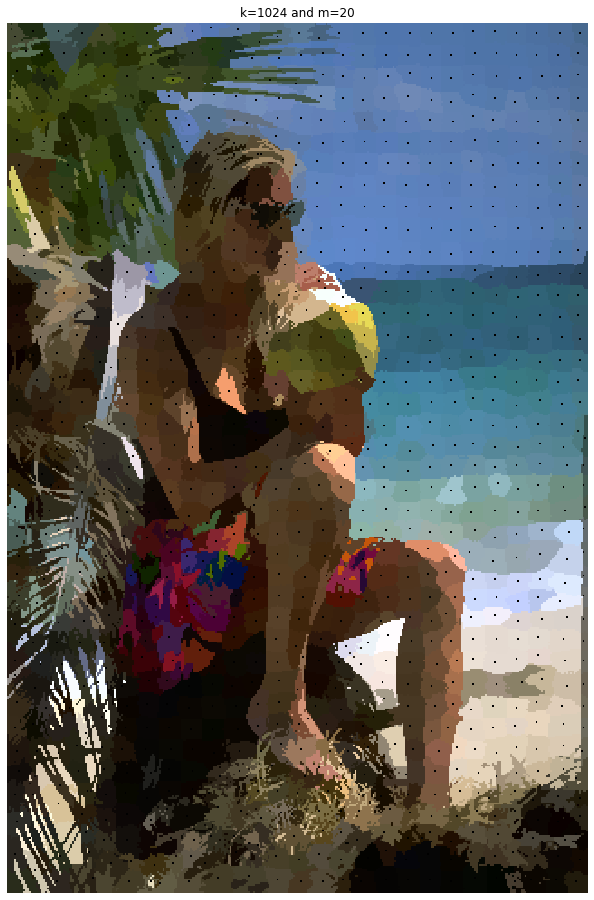

In [32]:
title_plot = str("k=1024 and m=20")
display_clusters(image , title_plot , clusters  )

### Write-up (35 pts)
* a) [5 points] Explain your distance function for measuring the similarity between a pixel and cluster in the 5D space.
* b) [5 points] Choose one image, try three different weights on the color and spatial feature and show the three segmentation results. Describe what you observe.
* c) [5 points] Choose one image, show the error (1) at the initialization and (2) at convergence. Note: error - distance to cluster center in the 5D space.
* d) [10 points] Choose one image and show three superpixel results with different number of K, e.g., 64, 256, 1024 and run time for each K.
* e)  [10 points] Run your algorithms on the subset (50 images) of Berkeley Segmentation Dataset (BSD) with K = 64, 256 and 1024 and report averaged run-time per image for the BSD.


### Extra Credit (20 pts)
* f) [upto 10 points] Implement and report two types of metrics (1) boundary recall and (2) under-segmentation error with K = 64, 256 and 1024 on the BSD (last part of write-up).
* g) [upto 10 points] Try to improve your result from first part of extra-credit. You may try different color space (e.g., CIELab, HSV) (See Sec 4.5 in the paper), richer image features (e.g., gradients) or any other ideas you come up with. Report the accuracy on boundary recall and under-segmentation error with K = 256. Compare the results with first-part of extra-credit and explain why you get better results.

### Hints 
- For main part, you CAN NOT use any library such as skimage / cv2 to perform or implement SLIC segmentation.
- For better visualization, you may use external function (skimage.segmentation.mark_boundaries) for your purpose.
- For EXTRA CREDIT part, you are allowed to use external library for metrics (boundary recall and under-segmentation error)

# ANSWERS:

  ##  a)
  *  The distance takes into account both the spatial distance between pixels and cluster center for a given window, and color space (cielab) as well. Ds= d_lab + (m/s)*d_xy. 

  Where d_lab and d_xy are the L2 norm between cluster centre and pixel in the respective spaces. Here 's' is the grid interval and variable 'm' allows to control the compactness of the superpixel. 

  ##  b)
  * 'm' is introduced in Ds allowing us to control
the compactness of a superpixel. The greater the value of m, the more spatial
proximity is emphasized and the more compact the cluster. Here below three m values are chosen '1' , '20' and '40'. And can be clearly seen that the cluster becomes more compact as more emphasis is given on spatial space than color space.

Runtime per iteration for 1 weights - 1.545329444548663s


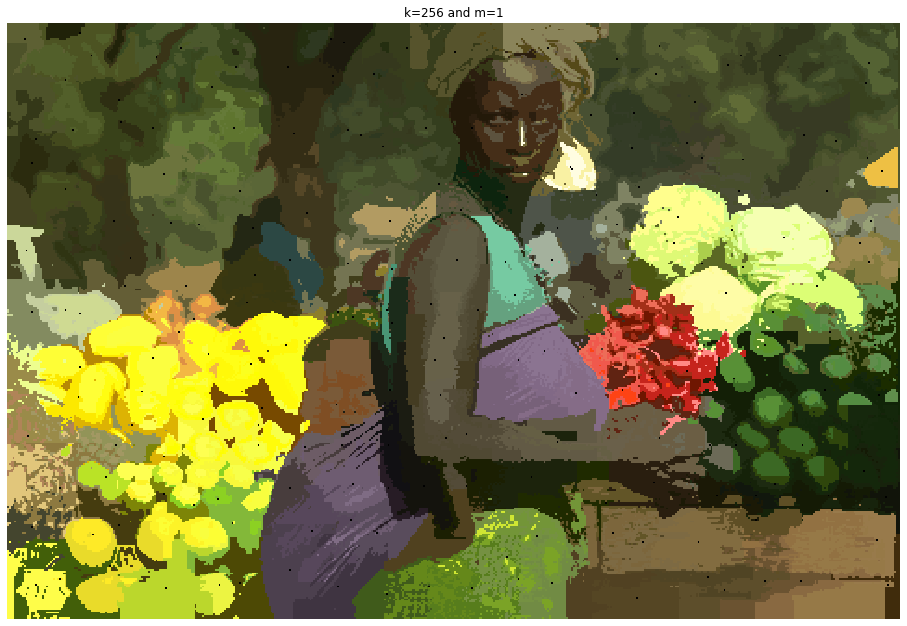

Runtime per iteration for 20 weights - 1.459418925372037s


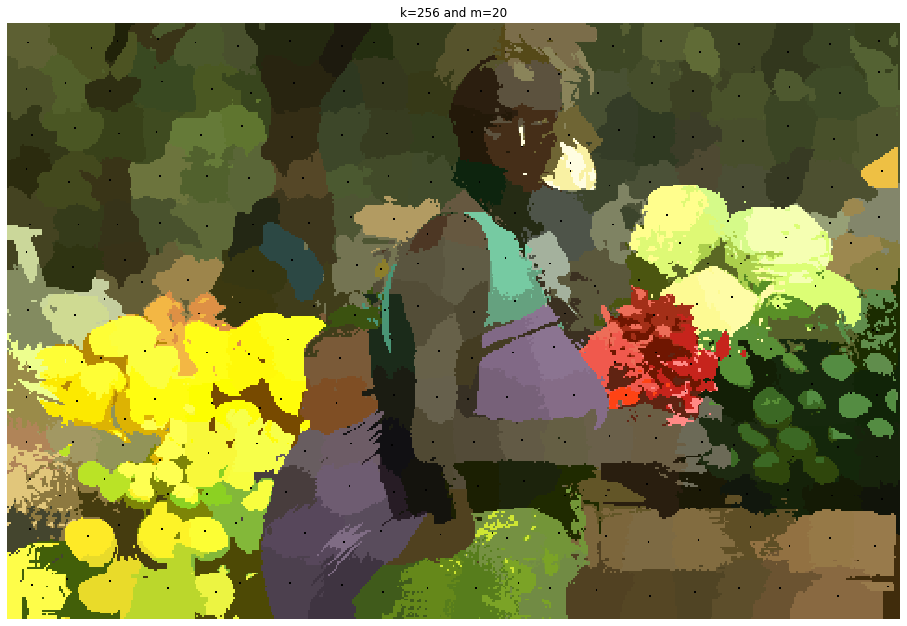

Runtime per iteration for 40 weights - 1.7187124382365833s


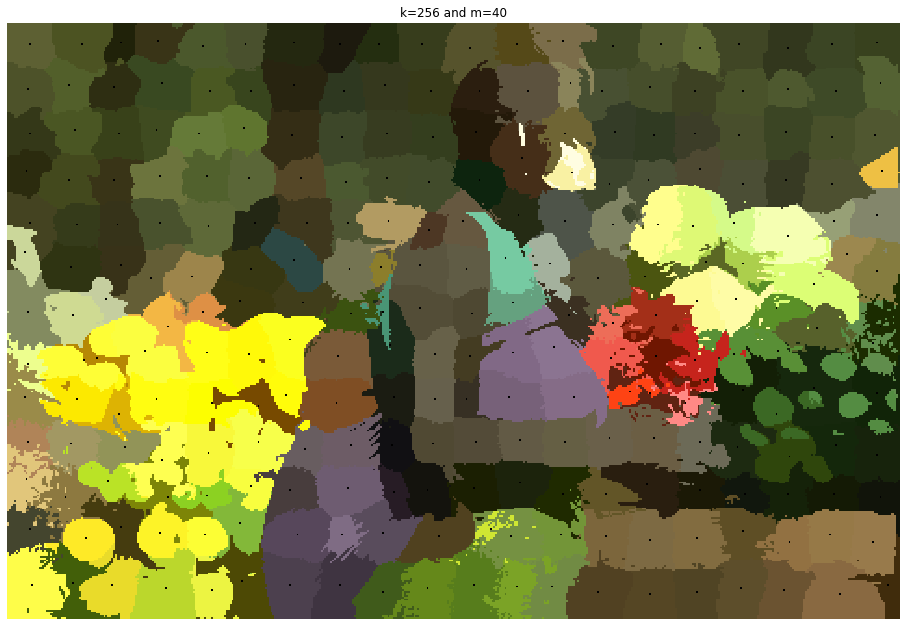

In [ ]:
# Main Block:
# img_path = "/content/Part1_SLIC/BSD_data/images/81090.jpg"
# img_path = "/content/Part1_SLIC/BSD_data/images/15011.jpg"
img_path = "/content/Part1_SLIC/BSD_data/images/16004.jpg"
image = img_as_float(io.imread(img_path))

image = color.rgb2lab(image)
img_h = image.shape[0] #  Height
img_w = image.shape[1] #  Width

K =  256 
M = [1 , 20 , 40]

for element in M:
    clusters , time_final , _= slic_algorithm(256 , element , image, img_h, img_w)
    print(f"Runtime per iteration for {element} weights - {time_final}s")
    title_plot = str(f"k={K} and m={element}")
    display_clusters(image , title_plot , clusters  )

   ## c) 
     * OUTPUT of the code block below

In [ ]:
img_path = "/content/Part1_SLIC/BSD_data/images/71076.jpg"

image = img_as_float(io.imread(img_path))

image = color.rgb2lab(image)
img_h = image.shape[0] #  Height
img_w = image.shape[1] #  Width

clusters , time_final , e_list= slic_algorithm(256 , 10 , image, img_h, img_w)
print(f"Runtime per iteration for {256} superpixels and {10} weights - {time_final}s")
print(f" Error at initialisation {e_list[0]}")
print(f" Error at convergence {e_list[-1]}")

Runtime per iteration for 256 superpixels and 10 weights - 1.4747242689132691s
 Error at initialisation 1215.0
 Error at convergence 0.0


  ##  d)
  *  Different number of superpixels

Runtime per iteration for 64 pixels and weights 10- 1.4691865921020508s


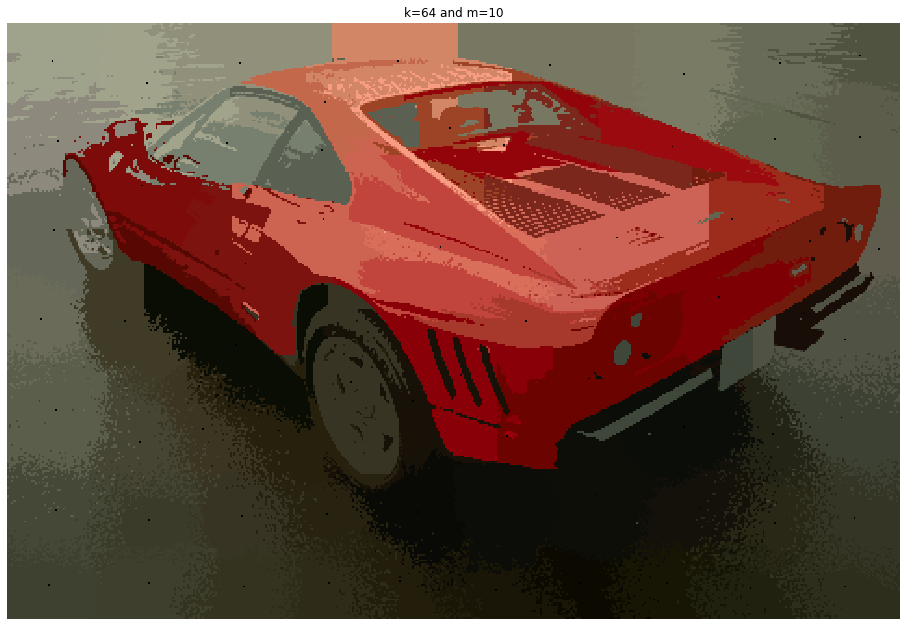

Runtime per iteration for 256 pixels and weights 10- 1.5747898817062378s


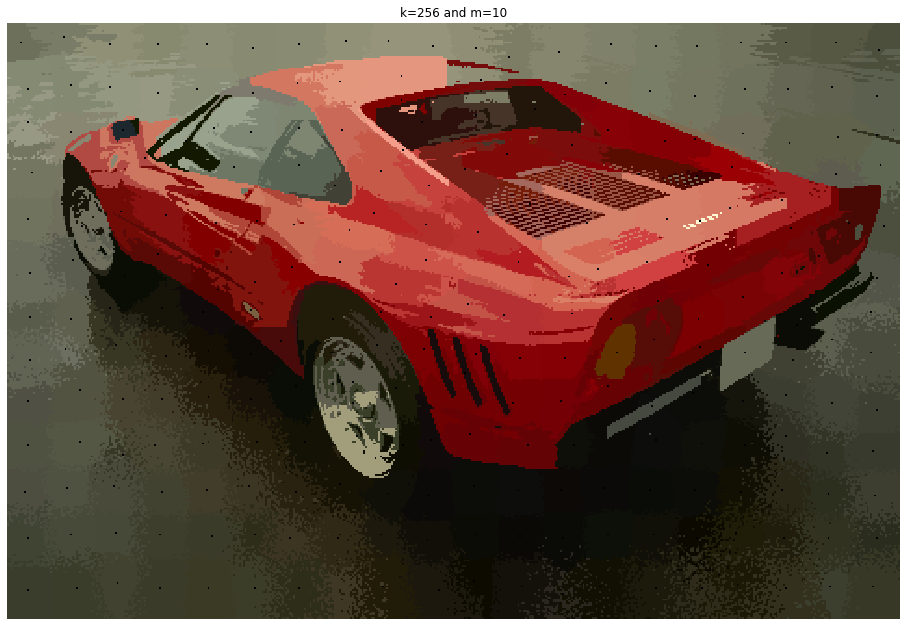

Runtime per iteration for 1024 pixels and weights 10- 1.7488604585329692s


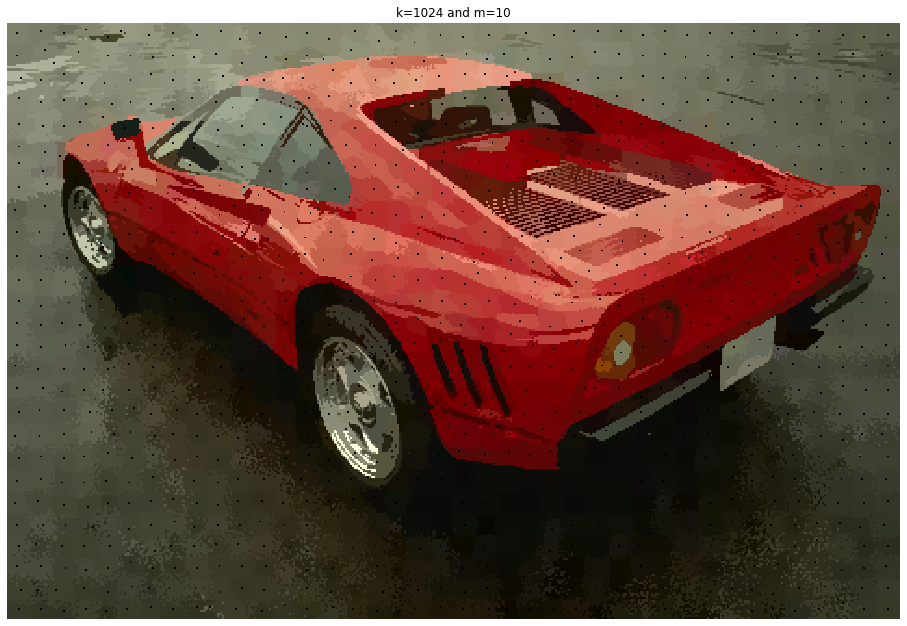

In [ ]:
img_path = "/content/Part1_SLIC/BSD_data/images/29030.jpg"

image = img_as_float(io.imread(img_path))

image = color.rgb2lab(image)
img_h = image.shape[0] #  Height
img_w = image.shape[1] #  Width

K = [64 , 256 , 1024]
M = 10

for element in K:
    clusters , time_final , _= slic_algorithm(element , M , image, img_h, img_w)

    print(f"Runtime per iteration for {element} pixels and weights {M}- {time_final}s")
    title_plot = str(f"k={element} and m={M}")
    display_clusters(image , title_plot , clusters  )


  ##  e)
  *  Runtime per iteration for 10 images of the BSD dataset. 


In [ ]:
def display_error(img_p):
  image = img_as_float(io.imread(img_path))
  image = color.rgb2lab(image)
  img_h = image.shape[0] #  Height
  img_w = image.shape[1] #  Width
  K = [64 , 256 , 1024]
  M = 10
  for element in K:
      clusters , time_final , _= slic_algorithm(element , M , image, img_h, img_w)
      print(f"Runtime per iteration for {element} pixels and weights {M}- {time_final}s")


img_path = "/content/Part1_SLIC/BSD_data/images/69007.jpg"
print(f"For image 69007")
display_error(img_path)

img_path = "/content/Part1_SLIC/BSD_data/images/41006.jpg"
print(f"For image 41006")
display_error(img_path)

img_path = "/content/Part1_SLIC/BSD_data/images/43051.jpg"
print(f"For image 43051")
display_error(img_path)

img_path = "/content/Part1_SLIC/BSD_data/images/45000.jpg"
print(f"For image 45000")
display_error(img_path)

img_path = "/content/Part1_SLIC/BSD_data/images/81066.jpg"
print(f"For image 81066")
display_error(img_path)

img_path = "/content/Part1_SLIC/BSD_data/images/65084.jpg"
print(f"For image 65084")
display_error(img_path)

img_path = "/content/Part1_SLIC/BSD_data/images/15062.jpg"
print(f"For image 15062")
display_error(img_path)

img_path = "/content/Part1_SLIC/BSD_data/images/2018.jpg"
print(f"For image 2018")
display_error(img_path)

img_path = "/content/Part1_SLIC/BSD_data/images/5096.jpg"
print(f"For image 5096")
display_error(img_path)

img_path = "/content/Part1_SLIC/BSD_data/images/41029.jpg"
print(f"For image 41029")
display_error(img_path)




For image 69007
Runtime per iteration for 64 pixels and weights 10- 1.4242003679275512s
Runtime per iteration for 256 pixels and weights 10- 1.4546475410461426s
Runtime per iteration for 1024 pixels and weights 10- 1.8419110434395927s
For image 41006
Runtime per iteration for 64 pixels and weights 10- 1.4337739944458008s
Runtime per iteration for 256 pixels and weights 10- 1.445736813545227s
Runtime per iteration for 1024 pixels and weights 10- 2.1271480917930603s
For image 43051
Runtime per iteration for 64 pixels and weights 10- 1.407859130339189s
Runtime per iteration for 256 pixels and weights 10- 1.5173821449279785s
Runtime per iteration for 1024 pixels and weights 10- 1.8701053749431262s
For image 45000
Runtime per iteration for 64 pixels and weights 10- 1.4410075119563512s
Runtime per iteration for 256 pixels and weights 10- 1.5770217378934224s
Runtime per iteration for 1024 pixels and weights 10- 1.7405997435251872s
For image 81066
Runtime per iteration for 64 pixels and weight

  ##  g)
  *  BONUS : color space changed to Ycbcr

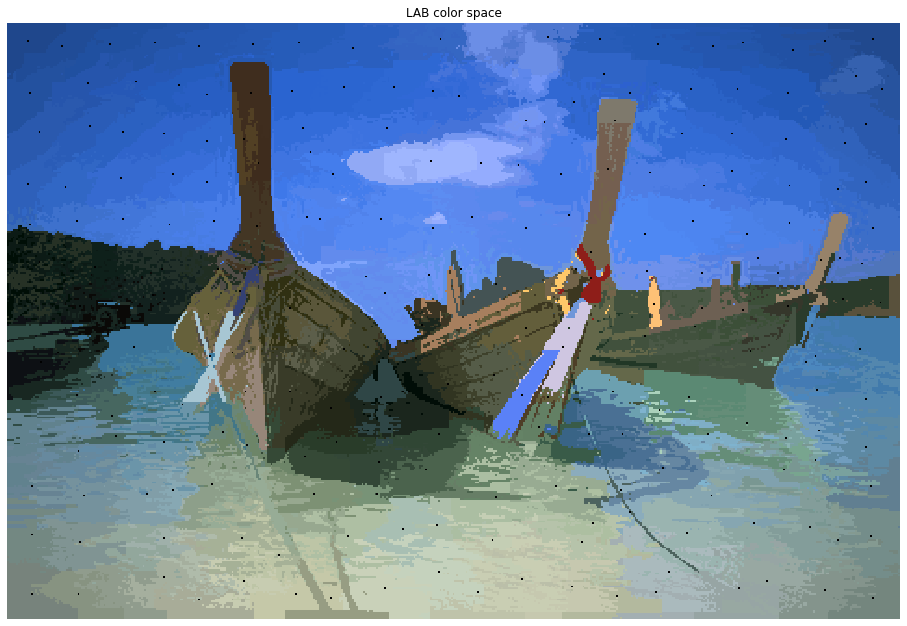

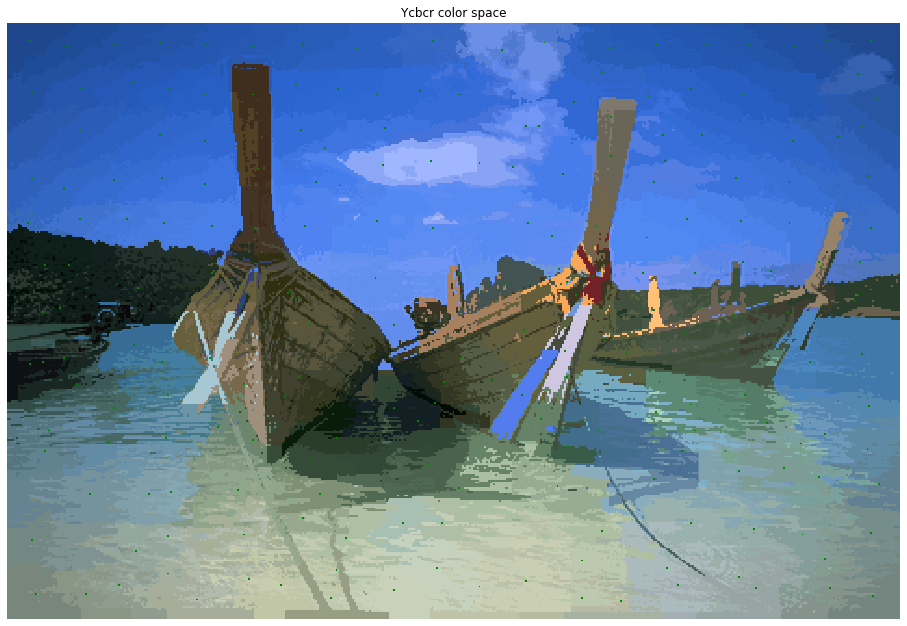

In [36]:
img_path = "/content/Part1_SLIC/BSD_data/images/81095.jpg"

image = img_as_float(io.imread(img_path))
# convert RGB to LAB
image = color.rgb2lab(image)
img_h = image.shape[0] #  Height
img_w = image.shape[1] #  Width
K =  256 
M = 1

clusters , time_final , _= slic_algorithm(K, M , image, img_h, img_w)
title_plot = str(f"LAB color space")
display_clusters(image , title_plot , clusters  )


image1 = img_as_float(io.imread(img_path))
# convert RGB to LAB
image1 = color.rgb2ycbcr(image1)
img_h = image1.shape[0] #  Height
img_w = image1.shape[1] #  Width

clusters , time_final , _= slic_algorithm(K, M , image1, img_h, img_w)
title_plot = str(f"Ycbcr color space")
display_clusters_ycb(image1 , title_plot , clusters  )


# Part 2: Graph-cut Segmentation (50 points)

## Overview

Let us apply Graph-cuts for foreground/background segmentation. In the “cat” image, you are given a rough polygon of a foreground cat. Apply graph-cut based method to see if we can get a better segmentation!

Firstly, use the provided polygon to obtain an estimate of foreground and background color likelihood. You may choose the likelihood distribution (e.g., color histograms or color mixture of Gaussians.).

Secondly, apply graph-cut code (cv2.grabcut) to do better segmentation. You can use the provided bounding-boxes and use "cv2 package" for the implementation sake. You are required to draw interesting conclusions on how it performs on different samples.

## Data 

In [40]:
# Download Data -- run this cell only one time per runtime
# !gdown 1ObpNoshjKMcB7SFvrTuoKe61IE-HG95n
!gdown 1Tw_gk0yylwl2X1leubz0mlERpxsqLiub
!unzip "/content/Part2_GraphCut.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=1Tw_gk0yylwl2X1leubz0mlERpxsqLiub
To: /content/Part2_GraphCut.zip
100% 264k/264k [00:00<00:00, 99.0MB/s]
Archive:  /content/Part2_GraphCut.zip
replace /content/Part2_GraphCut/dog.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Helper Functions

#### Code (15 pts)

In [90]:

def poly2mask(vertex_row_coords, vertex_col_coords, shape):
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, shape)
    mask = np.zeros(shape, dtype=np.bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask

# Get a normalized version of the given histograms (divide by sum)
def normalize_histograms(histograms):
  return np.float32([h / h.sum() for h in histograms])


In [91]:
def mask_for_fg(img, img_mask):
  """Generate foreground region (and everything else masked out)

  Args:
      img (numpy array): input image
      img_mask (numpy array): mask with boolean values

  Returns:
      numpy array: masked image
  """  
  # Blank black image initialised
  fg_image = np.zeros(img.shape , dtype=np.uint8)
  # Gettting indices were mask is true
  row , col = np.where(img_mask )
  # Storing pixel values where mask is true
  for r,c in np.nditer( [row,col] ):
    fg_image[r,c , :] = img[ r,c , :]

  return fg_image

def mask_for_bg(img, img_mask):
  """Generate background region (and everything else masked out)

  Args:
      img (numpy array): input image
      img_mask (numpy array): mask with boolean values

  Returns:
      numpy array: masked image
  """  
  bg_image = np.zeros(img.shape , dtype=np.uint8)
  mmask = img_mask.astype(int)
  # Gettting indices were mask is false
  row , col = np.where(mmask==0 )
  # Storing pixel values for the corresponding indices
  for r,c in np.nditer( [row,col] ):
    bg_image[r,c , :] = img[ r,c , :]

  return bg_image


def visualize_likelihood_map(gmm_bg, gmm_fg, img):
  """_summary_

  Args:
      gmm_bg (_type_): background gausian mixture model
      gmm_fg (_type_): foreground gausian mixture model
      img (numpy array): input image

  Returns:
      _type_: _description_
  """  
  # P(foreground/pixel) likelihood initialisation
  fg_score = np.zeros( ( 1 , img.shape[0]*img.shape[1]) )
  # img reshaped
  img_copy = img.reshape( (-1,3) )
  # Calculating the -ve log probability using GMM.score()
  for i in range(img_copy.shape[0]):
    fg_score[0 ,i] = gmm_fg.score( img_copy[i , :].reshape(1 , -1) )

  # Reshape
  map_like_fg = fg_score.reshape(img.shape[0] , img.shape[1])
  title_plot = str(f"P(pixel/foreground)")
  show_image(map_like_fg , title_plot , 2)


  # P(background/pixel) likelihood initialisation
  bg_score = np.zeros( ( 1 , img.shape[0]*img.shape[1]) )

  # Calculating the -ve log probability using GMM.score()
  for i in range(img_copy.shape[0]):
    bg_score[0 ,i] = gmm_bg.score( img_copy[i , :].reshape(1 , -1) )

  # Reshape
  map_like_fg = bg_score.reshape(img.shape[0] , img.shape[1])
  title_plot = str(f"P(pixel/background)")
  show_image(map_like_fg , title_plot ,2)

  return None

def gaussian_model(img):
  """Fitting gaussians for the given image

  Args:
      img (numpy array): input image

  """  
  # Shaping the data into 2D shape
  img_copy = img.reshape( (-1,3) )
  gmm_model, gmm_labels = None, None
  # Determining means and STD of 2 gaussians to fit the image
  gmm_model = GMM(n_components=2 , covariance_type='tied').fit(img_copy)
  # Testing the determined model on the given image
  gmm_labels = gmm_model.predict(img_copy)

  return gmm_model, gmm_labels

def run_grabcut(img, bbox , it_limit):
  """Initialising parameters for grabcut

  Args:
      img (numpy array): input image
      bbox (tuple(int)): starting coordinate and ,height and width of bounding box
      it_limit (int): number of iterations
  Returns:
      _type_: mask
  """  
  # You can use opencv cv2.grabCut algorithm with "cv2.GC_INIT_WITH_RECT" to implement this.
  grabcut_maskk = np.zeros(img.shape[:2],np.uint8)
  bgModel, fgModel = np.zeros((1,65) , np.float64), np.zeros((1,65) , np.float64)

  cv2.grabCut(img , grabcut_maskk ,bbox ,  bgModel , fgModel , it_limit , cv2.GC_INIT_WITH_RECT)

  grabcut_mask = np.where( (grabcut_maskk==2)|(grabcut_maskk==0), 0 , 1).astype('uint8')

  return (grabcut_mask, bgModel, fgModel)

def call_grabcut(img , bbox , count , name_img):
  """call and display mask and masked image

  Args:
      img (numpy array): input image
      bbox (tuple(int)): starting coordinate and ,height and width of bounding box
      count (int): number of iterations
  """  
  (grabcut_mask, bgModel, fgModel) = run_grabcut(img, bbox , count)
  title3 = ' iteration: '
  title1 = 'mask of '
  show_image(grabcut_mask , title1+name_img+title3+str( count) , 2)
  masked_img = img*grabcut_mask[:,:,np.newaxis]
  title2 = 'masked '
  show_image(masked_img , title2+name_img+title3+str( count) , 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


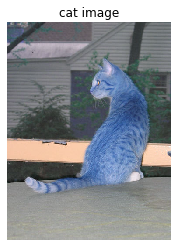

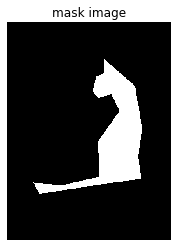

In [92]:
### Main Block: ###

# read image
img_name = 'cat'
img_path = '/content/Part2_GraphCut/cat.jpg'
img = cv2.imread(img_path)

# read image_mask
poly = scipy.io.loadmat('/content/Part2_GraphCut/cat_poly.mat')['poly']
img_mask = poly2mask(poly[:,1], poly[:,0], (img.shape[0],img.shape[1]))

show_image(img , 'cat image' , 1)
show_image(img_mask, 'mask image' , 1)

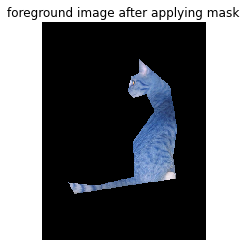

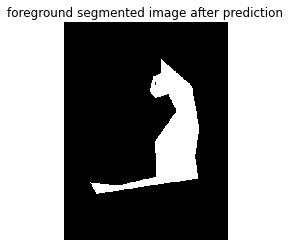

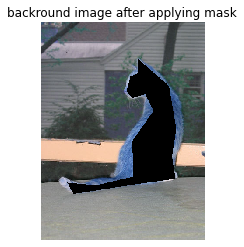

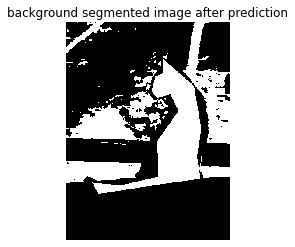

In [93]:
# 1. Fit Gaussian mixture model for foreground regions.

# Generate image (fg_image) with background masked using img_mask
fg_image = mask_for_fg(img, img_mask)

show_image( fg_image , 'foreground image after applying mask' , 1)

gmm_fg, fg_gmm_labels = gaussian_model(fg_image)

segmented_img_fg = fg_gmm_labels.reshape( img.shape[0] , img.shape[1])
show_image(segmented_img_fg , 'foreground segmented image after prediction' , 1)

# 2. Fit Gaussian mixture model for background regions.
# Generate image (fg_image) with foreground masked using img_mask
bg_image = mask_for_bg(img, img_mask)

show_image( bg_image , 'backround image after applying mask' , 1)

gmm_bg, bg_gmm_labels = gaussian_model(bg_image)

segmented_img_bg = bg_gmm_labels.reshape( img.shape[0] , img.shape[1])
show_image(segmented_img_bg , 'background segmented image after prediction' , 1)

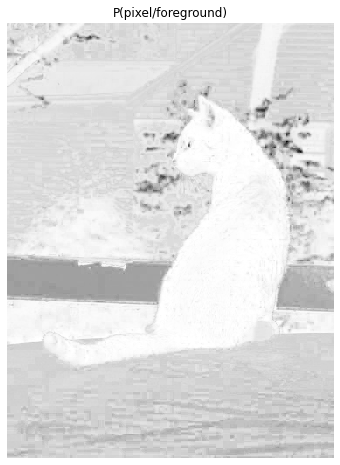

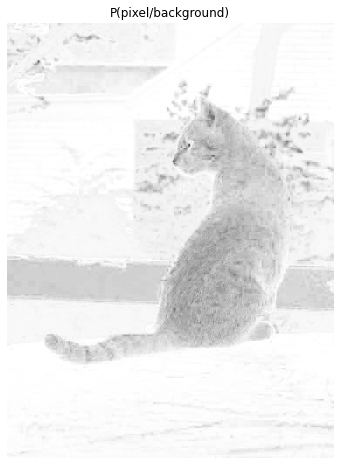

In [94]:
# 3. Compute and visualize the foreground cost and background cost as an image.
# Foreground label cost: -log Pr[Image | foreground model]
# Foreground label cost: -log Pr[Image | background model]

visualize_likelihood_map(gmm_bg, gmm_fg, img)


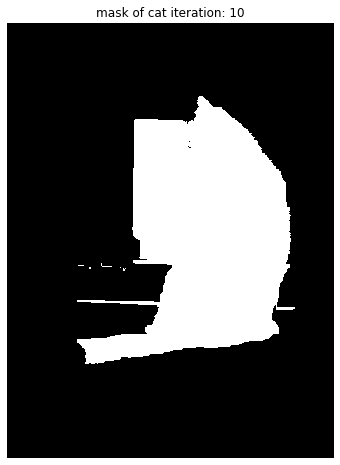

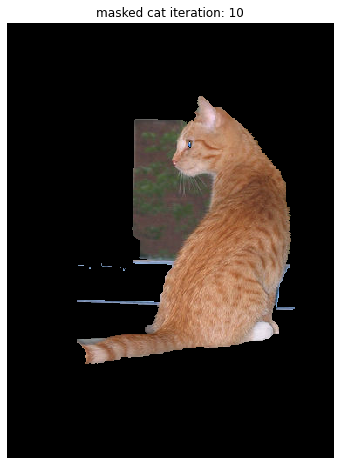

In [95]:
# 4. Run grabcut algorithm.
bboxes = {'cat':(80,80,320,250), 'dog':(50,300,600,300), 'plane': (180,80,250,800), 'messi':(10,80,600,500), 'bird':(100,100,350,250)}
bbox = bboxes[img_name]

rect = (bbox[1] , bbox[0] , bbox[3] ,bbox[2] )
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

call_grabcut(RGB_img , rect , 10 , img_name)

### Write-up (35 points)

- a) [5 points] Explain your foreground and background likelihood function.
- b) [10 points] Your foreground and background likelihood map. 

Display P(foreground|pixel) as an intensity map (bright = confident foreground).
- c) [15 points] Implement grabcut segmentation using cv2 package and draw insights on how the segmentation performs on different sample images (hard v/s easy).
- d) [5 points] Try grabcut algorithm with different "iterCount" to see if results improve in certain cases.

### Hints 
- You may refer to https://docs.opencv.org/4.x/dd/dfc/tutorial_js_grabcut.html to implement run_grabcut()

# ANSWERS:

# a) 
  * Gaussian mixture model objects are determined for the foreground image and backgorund image ,respectively. A model signifies the mean and variance(covariance matrix) for the gaussian. ANd each model have 2 gaussians associated with it. Firstly, the foreground model is taken and the -log Pr[Image | foreground model] value is determined for each pixel using score() function provided by sklearn. 
  * And similarly, backgorund model is taken and the -log Pr[Image | background model] value is determined for each pixel using score() function provided by sklearn. 

  ## b) 
  * The average log-likelihood of the data computed using score() function represents the map. And brighter the pixel(white in color) signifies more likely the event to occur given the distribution.
  * Here Both foreground and background fitted model are displayed.

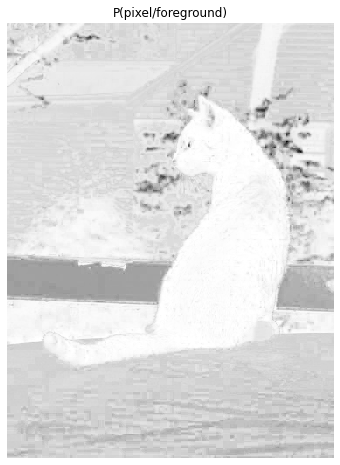

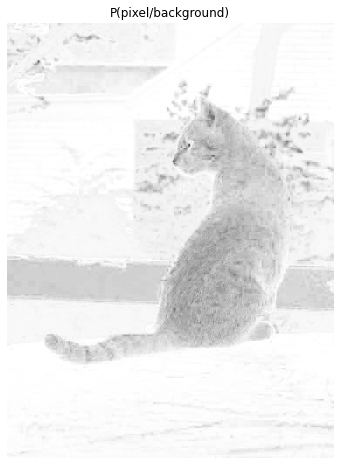

In [96]:
visualize_likelihood_map(gmm_bg, gmm_fg, img)

## c)
  * The segmentation basically works on the fitting of gaussians as foreground and background of the given image. First, the given buonding boxes are used for hard assignment,ie. region outside box is considered as background. And then graphcut is applied.
  * For the cat, the plants are considered as foreground as well. This output is subjective as some users consider just the cat as fireground but others consider plant and cat as foreground. ANd this is relatively hard picture, as the algorithm isn't able to successfully detect all the leaves in the picture separately(i.e leaves are present along side background).
  * The plane is perfectly cropped out as the background sky has distinct color compared to forground.
  * The dog lost part of its ear, not due to grabcut but due to incorrect dimensions of bounding box. Which accidently assigns the other part of ear as backgorund in the initial step itself.
  * The bird, output has done a decent job but due to similarity of background color and body color. Part of background is assigned as foreground.
  * The messi picture is completely fine as the distinct color of grass is assigned as backgorund during hard assignment itself. 

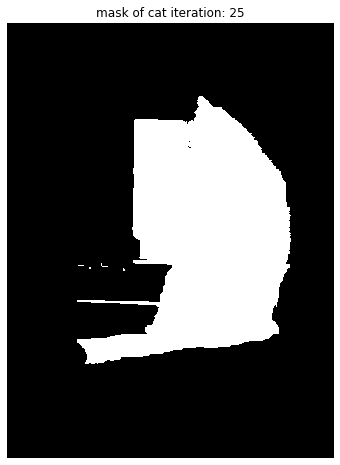

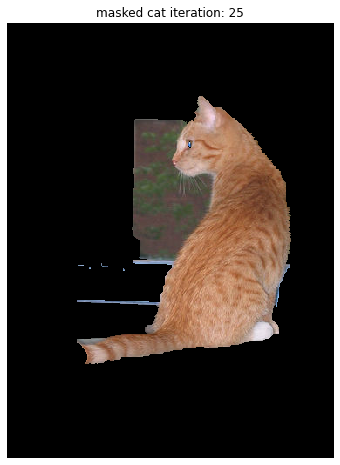

In [97]:
bbox = bboxes[img_name]
rect_cat = (bbox[1] , bbox[0] , bbox[3] ,bbox[2] )
RGB_img_cat = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
call_grabcut(RGB_img_cat , rect_cat , 25 , img_name)

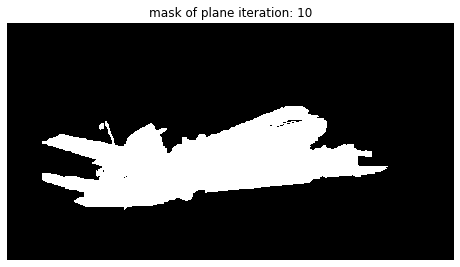

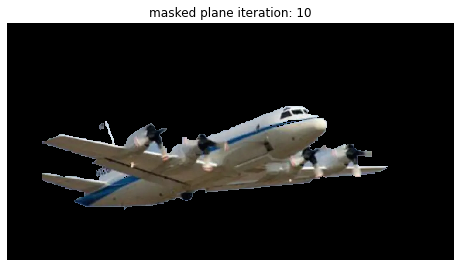

In [98]:
img_name = 'plane'
img_path = '/content/Part2_GraphCut/plane.jpg'
img = cv2.imread(img_path)
bbox = bboxes[img_name]
rect = (bbox[1] , bbox[0] , bbox[3] ,bbox[2] )
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
call_grabcut(RGB_img , rect , 10 , img_name)

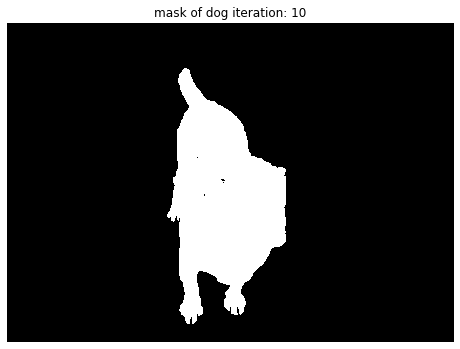

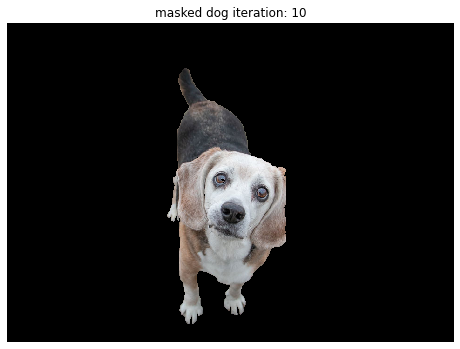

In [99]:
img_name = 'dog'
img_path = '/content/Part2_GraphCut/dog.jpg'
img = cv2.imread(img_path)
bbox = bboxes[img_name]
rect_dog = (bbox[1] , bbox[0] , bbox[3] ,bbox[2] )
RGB_img_dog = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
call_grabcut(RGB_img_dog , rect_dog , 10 , img_name)

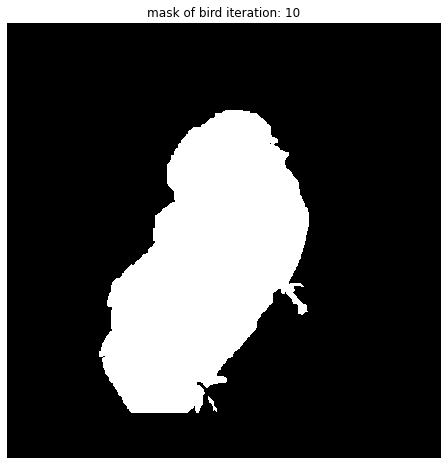

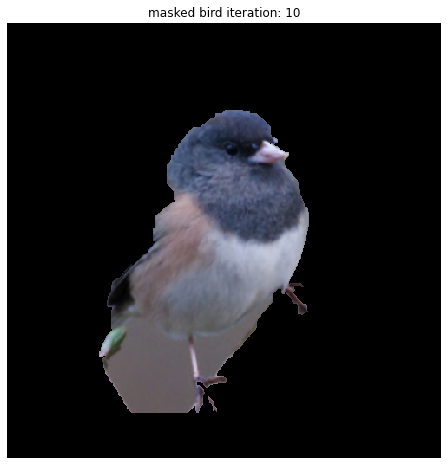

In [100]:
img_name = 'bird'
img_path = '/content/Part2_GraphCut/bird.jpg'
img = cv2.imread(img_path)
bbox = bboxes[img_name]
rect_bird = (bbox[1] , bbox[0] , bbox[3] ,bbox[2] )
RGB_img_bird = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
call_grabcut(RGB_img_bird , rect_bird , 10 , img_name)

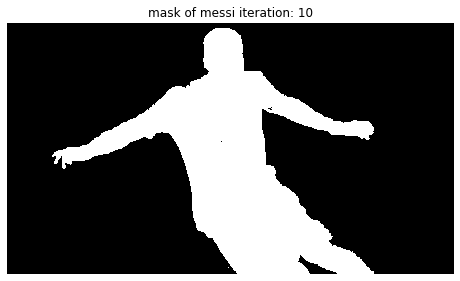

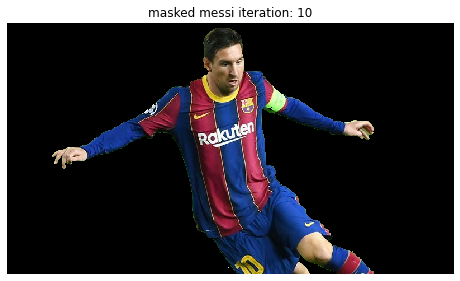

In [101]:
img_name = 'messi'
img_path = '/content/Part2_GraphCut/messi.jpg'
img = cv2.imread(img_path)
bbox = bboxes[img_name]
rect = (bbox[1] , bbox[0] , bbox[2] ,bbox[3] )
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
call_grabcut(RGB_img , rect , 10 , img_name)

## d) 
  * Increased number of iterations

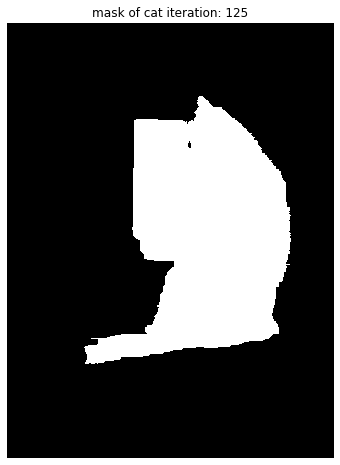

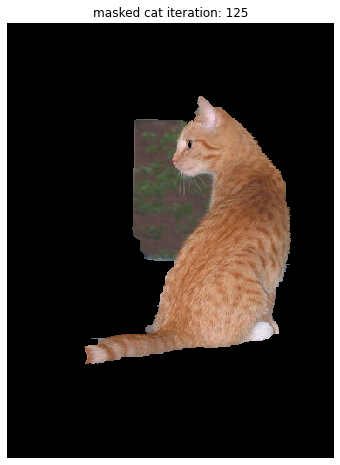

In [102]:
img_name='cat'
call_grabcut(RGB_img_cat , rect_cat , 125 , img_name)

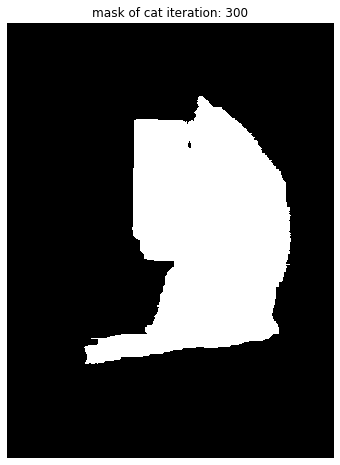

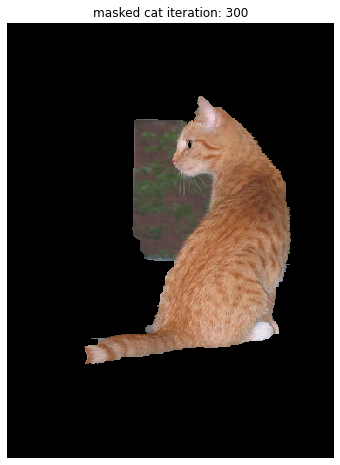

In [106]:

img_name='cat'
call_grabcut(RGB_img_cat , rect_cat , 300 , img_name)

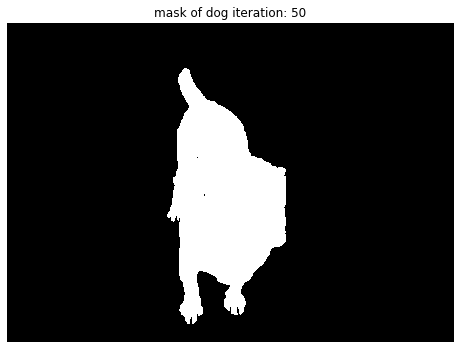

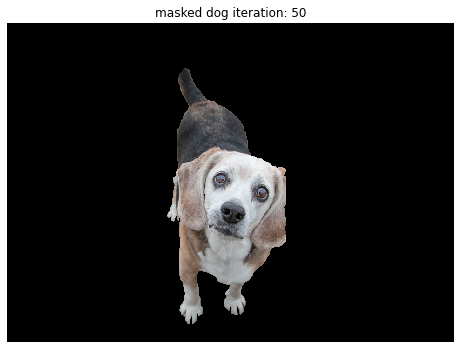

In [104]:
img_name='dog'
call_grabcut(RGB_img_dog , rect_dog , 50 , img_name)

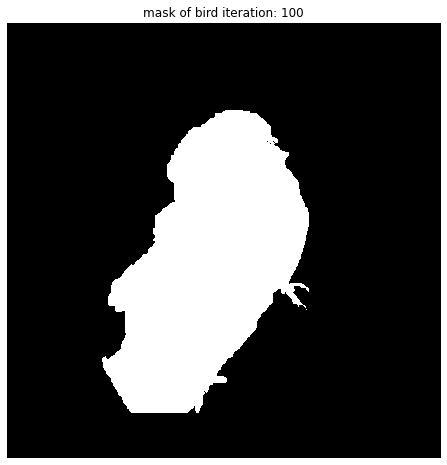

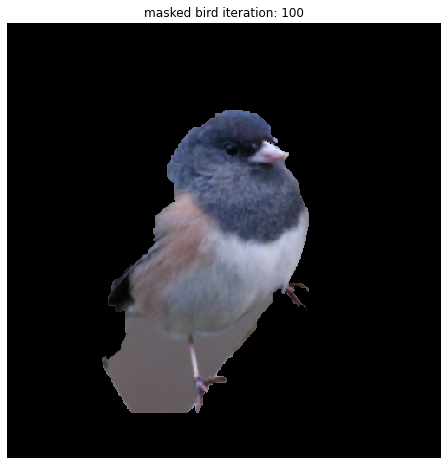

In [105]:
img_name='bird'
call_grabcut(RGB_img_bird , rect_bird , 100 , img_name)